In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, accuracy_score

### Primeiro Dataset

In [3]:
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables)

print(y)

{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

## Tratamento dos datasets

### Visualização de datasets

In [4]:
print("Features:")
print(X.head())
print("\nTargets:")
print(y)

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS  
0  Public_Transportation  
1  Public_Transportation  
2  Public_Transportation  
3                Walking  
4  Public_Transportation  

Tar

### Tratamento de Dados

In [5]:
# OneHotEncoder para as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_cols])

# Nomes das colunas para as variáveis categóricas
categorical_column_names = ohe.get_feature_names_out(categorical_cols)

# Normalizar atributos numéricos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

# Concatenar os dados (numéricos e categóricos)
X_processed = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Criar um DataFrame com os nomes das colunas
X_processed_df = pd.DataFrame(X_processed, columns=np.concatenate([numeric_cols, categorical_column_names]))

# Garantir que y seja 1D (caso contrário, aplicar squeeze)
if len(y.shape) > 1 and y.shape[1] == 1:  # Se y for 2D com uma única coluna
    y = y.squeeze()  # Converte para 1D

# Verificar se y é 1D
if len(y.shape) > 1:
    print("y ainda é multidimensional. Forma de y:", y.shape)
else:
    print("y é unidimensional.")

original_y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.squeeze()
y, uniques = pd.factorize(original_y)  # Agora y é seu vetor de rótulos numéricos
label_mapping = {i: label for i, label in enumerate(uniques)}  # Mapeamento correto


# Convertendo y para uma série do pandas para facilitar a visualização
y_series = pd.Series(y)

# Exibindo os dados processados e o target
print("Dados de entrada (X) processados:")
print(X_processed_df.head())

print("Target (y) original ajustado:")
print(np.unique(y))

y é unidimensional.
Dados de entrada (X) processados:
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0 -0.522124 -0.875589 -0.862558 -0.785019  0.404153 -0.013073 -1.188039   
1 -0.522124 -1.947599 -1.168077  1.088342  0.404153  1.618759  2.339750   
2 -0.206889  1.054029 -0.366090 -0.785019  0.404153 -0.013073  1.163820   
3  0.423582  1.054029  0.015808  1.088342  0.404153 -0.013073  1.163820   
4 -0.364507  0.839627  0.122740 -0.785019 -2.167023 -0.013073 -1.188039   

        TUE  Gender_Female  Gender_Male  ...  SCC_yes  CALC_Always  \
0  0.561997            1.0          0.0  ...      0.0          0.0   
1 -1.080625            1.0          0.0  ...      1.0          0.0   
2  0.561997            0.0          1.0  ...      0.0          0.0   
3 -1.080625            0.0          1.0  ...      0.0          0.0   
4 -1.080625            0.0          1.0  ...      0.0          0.0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bik

In [6]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (1477, 31)
Tamanho do conjunto de teste: (634, 31)
Tamanho dos rótulos de treino: (1477,)
Tamanho dos rótulos de teste: (634,)

Exemplo de X_train (primeiras 5 linhas):
[[-0.41891632  0.58167952  1.13522783 -1.15946224  0.40415272 -0.01307326
   0.79872359  0.17508057  0.          1.          0.          1.
   0.          1.          0.          0.          1.          0.
   1.          0.          1.          0.          0.          0.
   1.          0.          0.          0.          0.          1.
   0.        ]
 [-0.43995922  1.09344635  2.82808626  1.08834176  0.40415272  0.64626675
  -0.68485289 -0.02952107  1.          0.          0.          1.
   0.          1.          0.          0.          1.          0.
   1.          0.          1.          0.          0.          0.
   1.          0.          0.          0.          0.          1.
   0.        ]
 [-0.83735979 -0.01798139 -1.3972161  -2.65837916  1.68974045 -1.64490507
   1.16382038  0.561

In [7]:
#### Definição da Rede MLP

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes, dropout_rate, activation_fn):
        super(MLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last_dim, h))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class MLPClassifierTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_sizes=(100,), dropout_rate=0.3, learning_rate=0.001,
                 activation_fn=nn.ReLU, max_epochs=50, weight_decay=0.0,
                 early_stopping=True, patience=10, verbose=False):
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.max_epochs = max_epochs
        self.weight_decay = weight_decay
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

    def fit(self, X, y):
        from sklearn.model_selection import train_test_split
        X = np.array(X)
        y = np.array(y)

        self.input_dim_ = X.shape[1]
        self.output_dim_ = len(np.unique(y))
        self.model_ = MLP(self.input_dim_, self.output_dim_, self.hidden_sizes,
                          self.dropout_rate, self.activation_fn)

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model_.parameters(),
                               lr=self.learning_rate,
                               weight_decay=self.weight_decay)

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(self.max_epochs):
            self.model_.train()
            optimizer.zero_grad()
            outputs = self.model_(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            self.model_.eval()
            with torch.no_grad():
                val_outputs = self.model_(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.max_epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

            if self.early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = self.model_.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        if self.verbose:
                            print("Early stopping triggered.")
                        break

        if best_model_state:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.numpy()


In [10]:
param_dist = {
    'mlp__hidden_sizes': [(64,), (128,), (64, 32), (128, 64), (256, 128)],
    'mlp__dropout_rate': uniform(0.1, 0.5),
    'mlp__learning_rate': uniform(0.0001, 0.01),
    'mlp__activation_fn': [nn.ReLU, nn.LeakyReLU, nn.Tanh],
    'mlp__max_epochs': randint(30, 300),
    'mlp__weight_decay': uniform(1e-5, 1e-2),
    'mlp__early_stopping': [True],
    'mlp__patience': [10],  # ou outro valor
    'mlp__verbose': [False],  # ou True se quiser logs
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifierTorch())
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    random_state=42,
    verbose=2,
    scoring='accuracy'
)

In [11]:
#Treinamento

In [12]:
# Ajustar o modelo com os dados de treino
warnings.filterwarnings("ignore", category=FutureWarning)
random_search.fit(X_train, y_train)

# Obter o melhor modelo do Random Search
best_model = random_search.best_estimator_

# Fazer previsões nos dados de treino
y_train_pred = best_model.predict(X_train)

# Calcular as métricas de avaliação para o conjunto de treino
print("Métricas para os dados de treino:")
print(classification_report(y_train, y_train_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END mlp__activation_fn=<class 'torch.nn.modules.activation.Tanh'>, mlp__dropout_rate=0.49827149343011645, mlp__early_stopping=True, mlp__hidden_sizes=(64, 32), mlp__learning_rate=0.007896910002727693, mlp__max_epochs=50, mlp__patience=10, mlp__verbose=False, mlp__weight_decay=0.0015701864044243652; total time=   2.3s
[CV] END mlp__activation_fn=<class 'torch.nn.modules.activation.Tanh'>, mlp__dropout_rate=0.16974693032602092, mlp__early_stopping=True, mlp__hidden_sizes=(128, 64), mlp__learning_rate=0.00983755518841459, mlp__max_epochs=219, mlp__patience=10, mlp__verbose=False, mlp__weight_decay=0.000916064345328208; total time=   0.7s
[CV] END mlp__activation_fn=<class 'torch.nn.modules.activation.Tanh'>, mlp__dropout_rate=0.18526206184364577, mlp__early_stopping=True, mlp__hidden_sizes=(128,), mlp__learning_rate=0.009588855372533333, mlp__max_epochs=43, mlp__patience=10, mlp__verbose=False, mlp__weight_decay=0.0080939

In [13]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")

# Exibir relatório com nomes de rótulos
target_names = [label_mapping[i] for i in sorted(label_mapping)]
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))


Melhores hiperparâmetros encontrados:
{'mlp__activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'mlp__dropout_rate': np.float64(0.14998745790900145), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (64, 32), 'mlp__learning_rate': np.float64(0.008761761457749352), 'mlp__max_epochs': 129, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.001438668179219408)}
Acurácia no conjunto de teste: 93.85%
Relatório de Classificação:
                     precision    recall  f1-score   support

      Normal_Weight       0.88      0.92      0.90        86
 Overweight_Level_I       0.94      0.87      0.90        87
Overweight_Level_II       0.88      0.95      0.92        87
     Obesity_Type_I       0.98      0.92      0.95       106
Insufficient_Weight       0.95      0.94      0.94        82
    Obesity_Type_II       0.95      0.98      0.96        89
   Obesity_Type_III       0.99      0.98      0.98        97

           accuracy                           

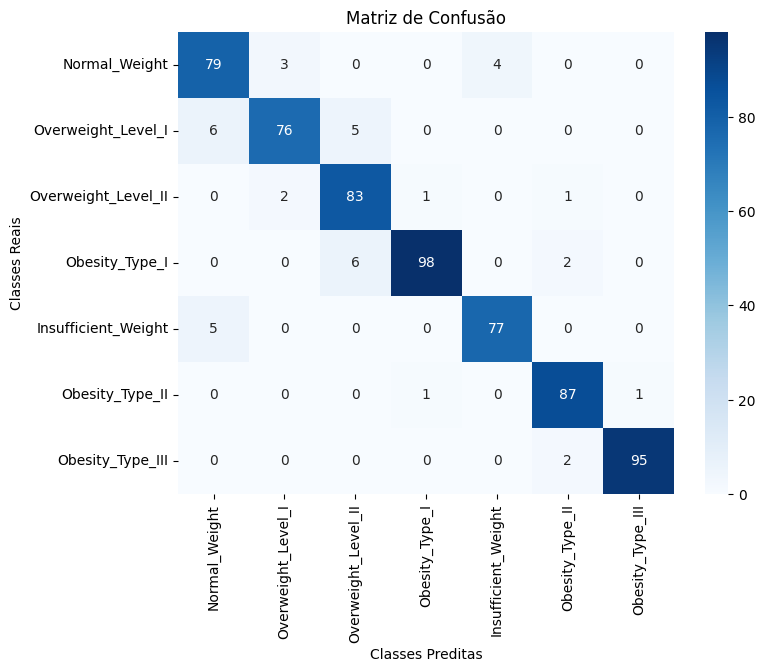

In [14]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Recuperar os nomes das classes a partir do y_test (ou y_train)
class_names = np.unique(y_test)
# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusão")
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Reais")
plt.savefig("matriz_confusao_1.png", dpi=300, bbox_inches='tight')
plt.show()